# Basic regression: Predict fuel efficiency


### Use seaborn for pairplot
!pip install -q seaborn

### Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

## This example uses the tf.keras API, see this guide for details.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto MPG dataset
- The dataset is available from the UCI Machine Learning Repository.

### Get the data

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\wrl\\.keras\\datasets\\auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data
- The dataset contains a few unknown values.

### 누락 데이터 포착 
#### isnull() or isna()
- 데이터프레임의 isnull 또는 isna 메서드를 사용하면 누락 데이터의 위치를 알 수 있다.
- 데이터가 많은 경우에는 일일히 볼 수 없으므로 sum 명령으로 누락데이터의 갯수를 셀 수 있다.

isnull().sum()  or isna().sum

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

#### missingno 패키지를 사용하면 누락데이터에 대한 시각화를 쉽게 할 수 있다. 


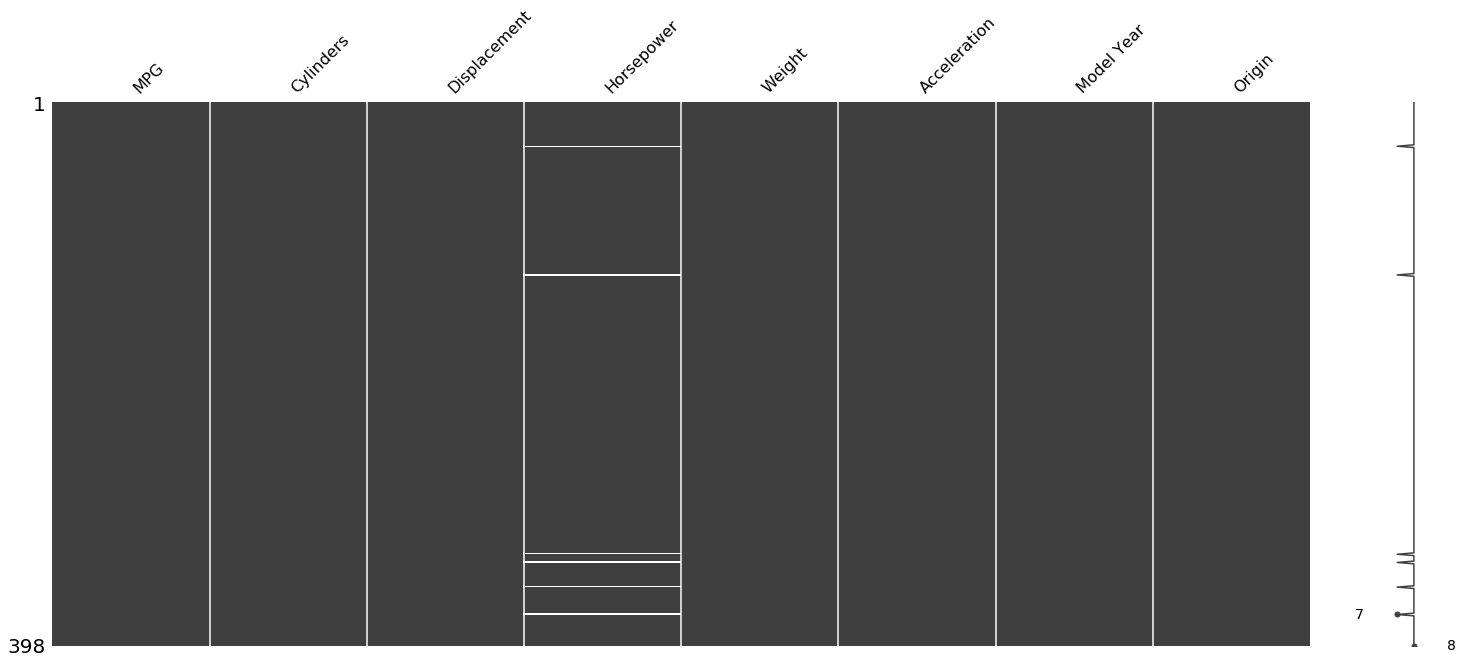

In [7]:
import missingno as msno

msno.matrix(dataset)
plt.show()

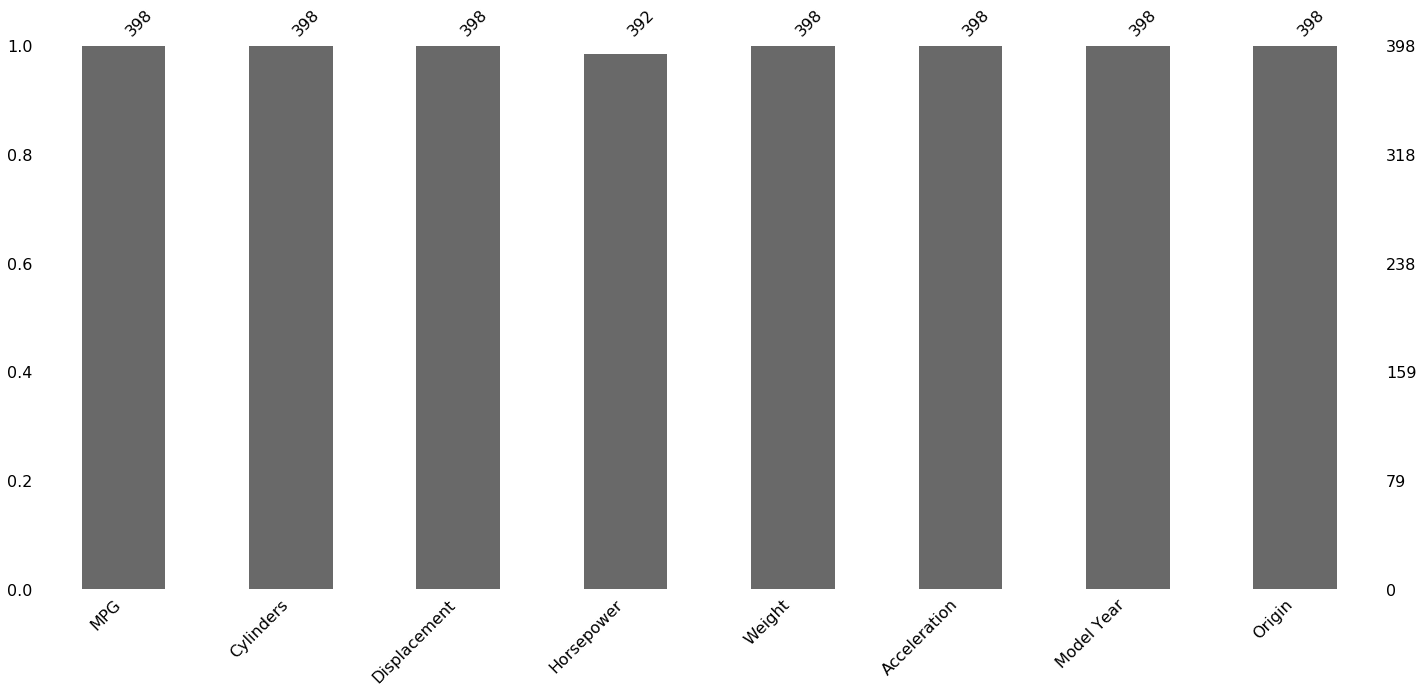

In [8]:
msno.bar(dataset)
plt.show()

### 누락 데이터 제거
-  dropna()명령을 사용하면 누락 데이터가 존재하는 행이나 열을 지울 수 있다.

In [9]:
dataset = dataset.dropna()

In [10]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test
- train: 80%, test 20%

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
146,28.0,4,90.0,75.0,2125.0,14.5,74,USA
282,22.3,4,140.0,88.0,2890.0,17.3,79,USA
69,12.0,8,350.0,160.0,4456.0,13.5,72,USA
378,38.0,4,105.0,63.0,2125.0,14.7,82,USA
331,33.8,4,97.0,67.0,2145.0,18.0,80,Japan


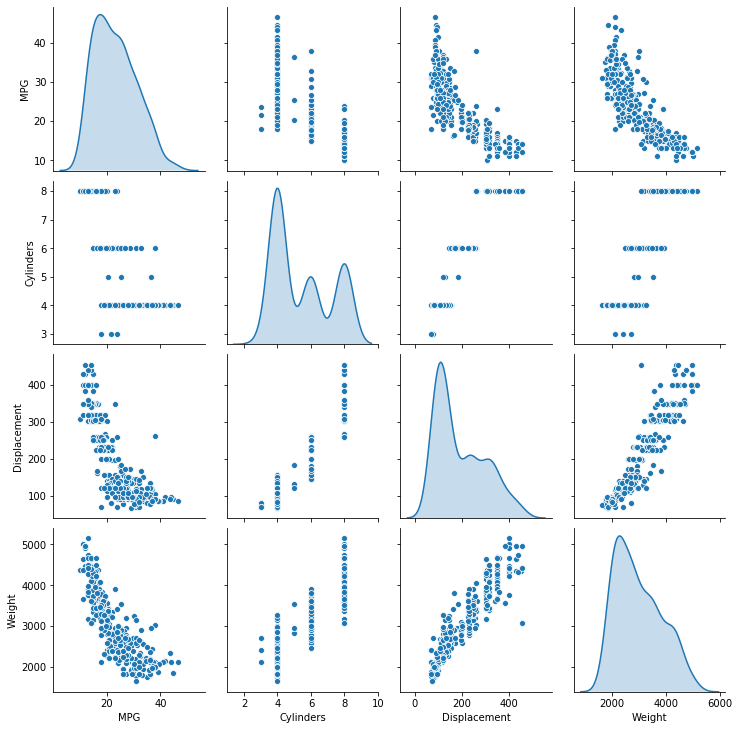

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### look at the overall statistics

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### "Split features from labels"
- Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
train_labels

KeyError: 'MPG'

### Normalize the data
- Look again at the train_stats block above and note how different the ranges of each feature are.
- It is good practice to normalize features that use different scales and ranges. 
- Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [14]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### Build the model
- Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [35]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape'])
  return model

In [36]:
model = build_model()

### Inspect the model

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


#### Take a batch of 10 examples from the training data and call model.predict on it.

- model.predict

In [38]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.33390784],
       [ 0.14339101],
       [ 0.27782267],
       [ 0.37825957],
       [ 1.0507605 ],
       [-0.0937745 ],
       [ 1.0872194 ],
       [ 0.77993137],
       [ 0.03752135],
       [ 0.89110816]], dtype=float32)

### Train the model
- 1000 epochs


In [40]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.9974,  mae:1.3758,  mape:5.8116,  mse:3.9974,  val_loss:9.0801,  val_mae:2.4081,  val_mape:10.6214,  val_mse:9.0801,  
....................................................................................................
Epoch: 100, loss:3.8938,  mae:1.3402,  mape:5.6677,  mse:3.8938,  val_loss:9.0268,  val_mae:2.2936,  val_mape:10.4025,  val_mse:9.0268,  
....................................................................................................
Epoch: 200, loss:3.3039,  mae:1.2564,  mape:5.3174,  mse:3.3040,  val_loss:10.0717,  val_mae:2.5402,  val_mape:11.3562,  val_mse:10.0717,  
....................................................................................................
Epoch: 300, loss:3.1776,  mae:1.2139,  mape:5.2282,  mse:3.1776,  val_loss:9.7688,  val_mae:2.4745,  val_mape:10.9703,  val_mse:9.7688,  
....................................................................................................
Epoch: 400, loss:2.8081,  mae:1.1012,  mape

In [41]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,mape,val_loss,val_mae,val_mse,val_mape,epoch
995,1.981698,0.914878,1.981699,3.799827,10.107842,2.426474,10.107842,11.391710,995
996,1.773368,0.826747,1.773368,3.433789,11.085039,2.705765,11.085038,12.177267,996
997,1.739157,0.829855,1.739157,3.448317,9.710736,2.473615,9.710736,11.343512,997
998,1.851930,0.893282,1.851930,3.830206,10.198859,2.554732,10.198858,11.603932,998
999,2.064682,0.939970,2.064682,4.006539,9.816108,2.535332,9.816108,11.733534,999


In [21]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

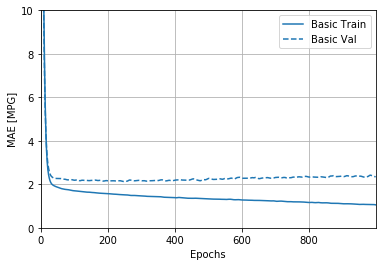

In [22]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

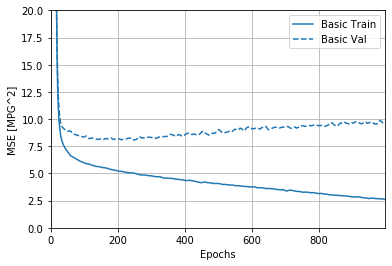

In [23]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [24]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:544.6801,  mae:22.1377,  mse:544.6801,  val_loss:526.0575,  val_mae:21.7552,  val_mse:526.0575,  
.......................................................................

Text(0, 0.5, 'MAE [MPG]')

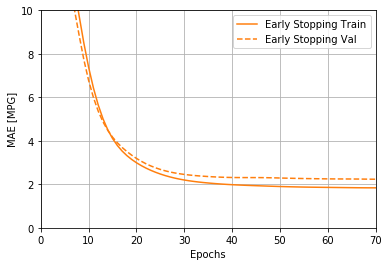

In [25]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [26]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.7022 - mae: 1.8284 - mse: 5.7022
Testing set Mean Abs Error:  1.83 MPG


### Make predictions
- predict MPG values using data in the testing set

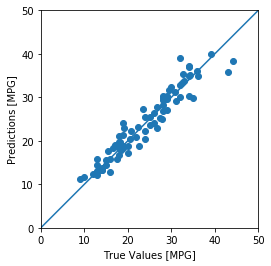

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


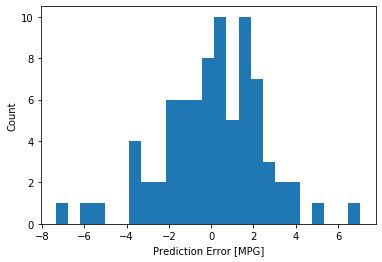

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")